## 1. データの読み込みと前処理


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import seaborn as sns
import rdrobust
import rddensity
import causalpy as cp

import warnings
warnings.filterwarnings('ignore')

# DID

- 下記の回帰を実施する
```math
y = \beta_0 + \beta_1 \text{group} + \beta_2 \text{post\_treatment} + \beta_3 (\text{group} \times \text{post\_treatment}) + \epsilon
```

In [2]:
df_org = cp.load_data('did')

In [3]:
df = df_org.copy()
df['group_x_post_treatment'] = df['group'] * df['post_treatment']

In [4]:
df.describe()

,group,t,unit,y,group_x_post_treatment
count,40.00000,40.00000,40.00000,40.000000,40.000000
mean,0.50000,0.50000,9.50000,1.775977,0.250000
std,0.50637,0.50637,5.83974,0.677748,0.438529
min,0.00000,0.00000,0.00000,0.897122,0.000000
25%,0.00000,0.00000,4.75000,1.194504,0.000000
50%,0.50000,0.50000,9.50000,1.602451,0.000000
75%,1.00000,1.00000,14.25000,2.326897,0.250000
max,1.00000,1.00000,19.00000,2.836235,1.000000


In [5]:
def plot_distribution(df, X_cols, t_col):
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))
    axs = axs.flatten()
    for i, col in enumerate(X_cols):
        ax = axs[i]
        sns.histplot(data=df, x=col, hue=t_col, stat='density', common_norm=False, ax=ax, alpha=0.5)
        # 点で平均を表示
        ax.scatter(df.loc[df[t_col] == 1, col].mean(), 0, alpha=0.5, color='orange', s=100, zorder=5, label='Treated Mean')
        ax.scatter(df.loc[df[t_col] == 0, col].mean(), 0, alpha=0.5, color='blue', s=100, zorder=5, label='Treated Mean')
    plt.tight_layout()

In [6]:
df.columns

Index(['group', 't', 'unit', 'post_treatment', 'y', 'group_x_post_treatment'], dtype='object')

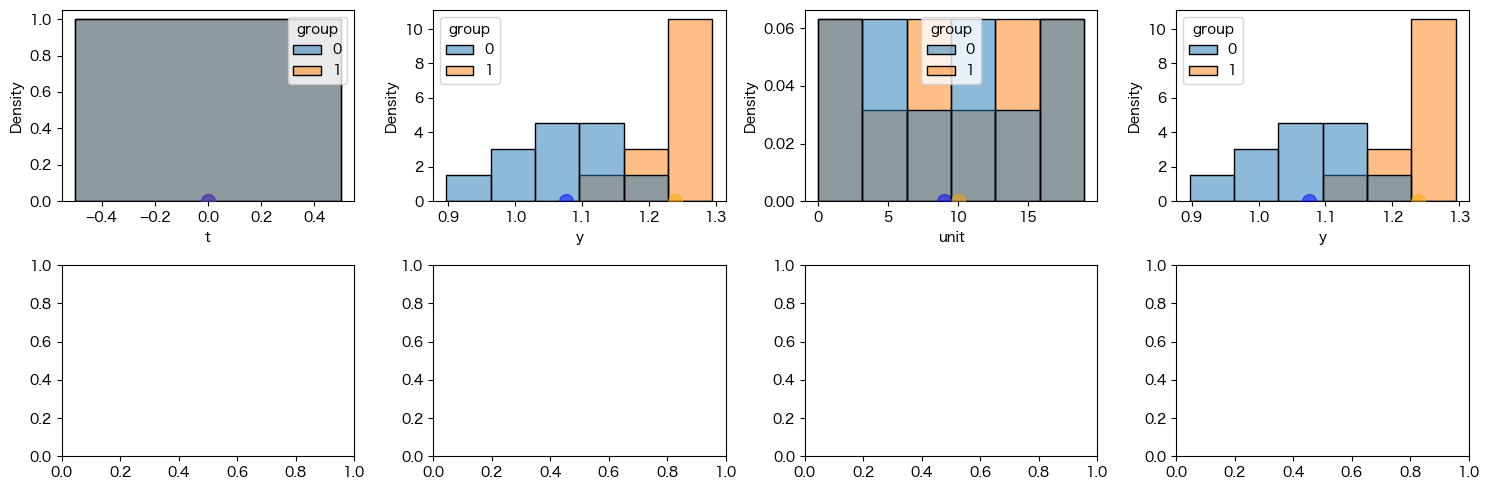

In [7]:
plot_cols = ['t', 'y', 'unit', 'y'] 
plot_distribution(df.query('post_treatment==0'), plot_cols, 'group')

<Axes: xlabel='y', ylabel='Count'>

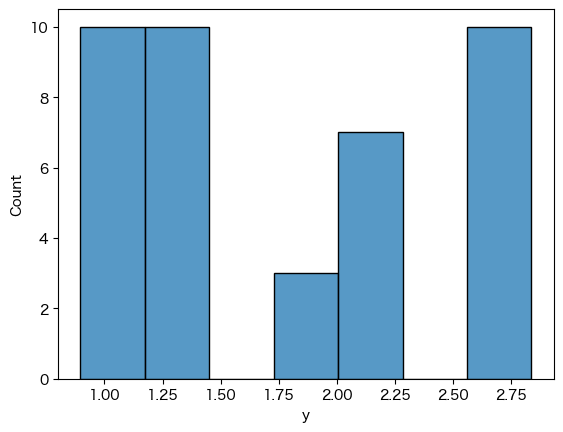

In [8]:
sns.histplot(df['y'])

In [9]:
# OLSによるDID推定
# データ型を数値型に変換
X = sm.add_constant(df[['group', 'post_treatment', 'group_x_post_treatment']].astype(float))
y = df['y'].astype(float)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     938.3
Date:                Wed, 31 Dec 2025   Prob (F-statistic):           3.23e-34
Time:                        19:10:53   Log-Likelihood:                 46.746
No. Observations:                  40   AIC:                            -85.49
Df Residuals:                      36   BIC:                            -78.74
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

# SC
- 緊急事態宣言の発出が商業施設の売上に与える影響

In [10]:
df = cp.load_data('sc')

In [13]:
treatment_time = 70
seed = 42

In [12]:
df

,a,b,c,d,e,f,g,counterfactual,causal effect,actual
0,0.793234,1.277264,-0.055407,-0.791535,1.075170,0.817384,-2.607528,0.144888,-0.000000,0.398287
1,1.841898,1.185068,-0.221424,-1.430772,1.078303,0.890110,-3.108099,0.601862,-0.000000,0.491644
2,2.867102,1.922957,-0.153303,-1.429027,1.432057,1.455499,-3.149104,1.060285,-0.000000,1.232330
3,2.816255,2.424558,0.252894,-1.260527,1.938960,2.088586,-3.563201,1.520801,-0.000000,1.672995
4,3.865208,2.358650,0.311572,-2.393438,1.977716,2.752152,-3.515991,1.983661,-0.000000,1.775940
...,...,...,...,...,...,...,...,...,...,...
95,25.175929,26.986002,14.483402,15.792217,31.376095,29.344142,20.592599,22.098248,-0.007300,21.995991
96,24.965067,26.939116,14.436928,16.205108,31.279158,29.223181,20.369925,22.337562,-0.003822,22.226816
97,25.083953,26.389334,14.633898,16.971333,31.012904,29.746146,20.522976,22.579706,-0.001975,22.739195
98,25.086801,27.157119,15.128901,17.777625,30.897634,30.160289,20.911121,22.824786,-0.001008,22.784751


In [14]:
result= cp.SyntheticControl(
    df,
    treatment_time,
    control_units=['a', 'b', 'c', 'd', 'e', 'f', 'g'],
    treated_units=['actual'],
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={
            'target_accept': 0.95,
            'random_seed': seed,
            'progressbar': False
        }
    )
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


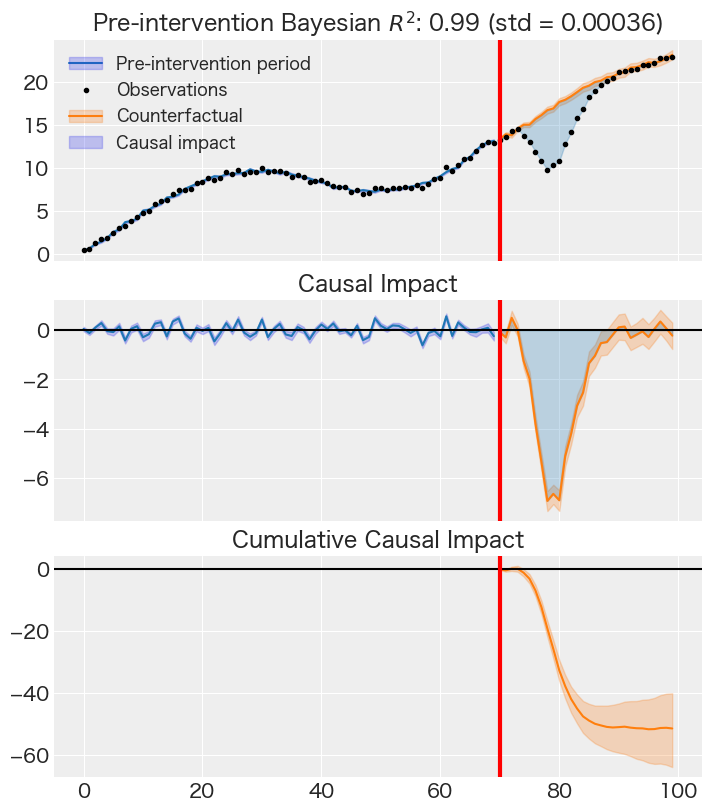

In [15]:
fig, ax = result.plot(
    figsize=(10, 6),
    title='Synthetic Control Method Results',
    ylabel='Outcome Variable',
    xlabel='Time'
)